# Predicting hotel reviews rating

With the increasing availability of social feedback on platforms such as Yelp or TripAdvisor, more and more customers consult reviews before making their next decision about a purchase, airplane ticket or hotel reservation. In the case of hotels, 90% of travelers agree that reviews are influential when making a decision on where to stay. These customers also trust the reviews that they find as much as personal recommendations (Brightlocal.com). If reviews are not positive enough, it could amount to losing 88% of web traffic that references reviews. In addition, 75% of consumers complete a call to action after reading a great review.

From the business perspective, customer reviews contain a large amount of information that can help identify current issues and fix them, customer satisfaction, and customer loyalty. However, in order to obtain this information, involves reading through a great number of these reviews, which in turn, may required a number of readers analyzing the texts for a large number of hours.

This project aims to helping with this issue, specifically hotel reviews, by applying NLP to catalog customer reviews as positive or negative.

The main benefit of this product is to save hours of going through the reviews and follow a consistent pattern in cataloging them. In addition, for those reviews that are not accompanied by a rating (eg. 3 stars), this product will be able to make predictions as to the review rating. By saving the bussiness working hours, this time can be spent in other tasks such as targeting issues or implementing new marketing strategies. Thus, the main beneficiaries of these product are hotel companies as well as online platforms dedicated to provide a place to stay. 

## Data

The dataset used for this project contains 35050 reviews for hotels in the United States. In addition to the review itself (textual), a review title is provided as well as the hotel rating (from 0 to 10). Metadata about the hotel being reviewed is also provided: name, address, category, date. Metadata about the reviewer is also provided: username, city, and province.  

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use('ggplot')
%matplotlib inline

import re

from wordcloud import STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_curve, auc

from sklearn.utils import resample

In [2]:
data = pd.read_csv('/Users/danielvalle/Documents/Coding/Springboard/Capstone project 2 - NLP/Hotel reviews.csv', encoding='latin-1')

In [3]:
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt lÀ_À_ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,À_À_À_À_À_À_ À_À_À_À_À_À_À_À_À_...,NaN,sungchul,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35912 entries, 0 to 35911
Data columns (total 19 columns):
address                 35912 non-null object
categories              35912 non-null object
city                    35912 non-null object
country                 35912 non-null object
latitude                35826 non-null float64
longitude               35826 non-null float64
name                    35912 non-null object
postalCode              35857 non-null object
province                35912 non-null object
reviews.date            35653 non-null object
reviews.dateAdded       35912 non-null object
reviews.doRecommend     0 non-null float64
reviews.id              0 non-null float64
reviews.rating          35050 non-null float64
reviews.text            35890 non-null object
reviews.title           34290 non-null object
reviews.userCity        16263 non-null object
reviews.username        35869 non-null object
reviews.userProvince    17518 non-null object
dtypes: float64(5), 

## Data wrangling and cleaning

First, those reviews which do not show a rating will be dropped since they do not help us in establishing the ground truth for the sentiment associated with the review. 

As a starting point, reviews rated as 5 or higher will be considered positive while those rated below 4 will be considered as negative. From this, we can see that negative reviews outnumber positive ones. We will keep this in mind for considering techniques to deal with imbalanced data. 

Then, we move on to cleaning the text: make sure that reviews are strings, convert them to lower case and delete non alphanumerical characters. 

Then, we are ready to split the data into train and test sets. In the next step, we fit and transform each review in the train set into a numerical vector having as features each each word (attested at least two times) and contiguous sequences of two words (bigrams). Then, this matrix is further fitted and transformed via tf-idf transformer. A similar process is applied to the test data with the difference that only the transformations are applied; the fitting step is skipped since the same fitting of the train data is used in order to allow for the same set of features (words and bigrams) in both train and test samples. During this process of fitting and transformation, stopwords were also removed.

In [5]:
# Drop null values of ratings
data = data[data['reviews.rating'].notnull()]

In [6]:
# Create column with binary values for sentiment
data["sentiment"] = [1 if x >= 5 else 0 for x in data['reviews.rating']]

Text(0.5,1,"Hotel review sentiment (1 = 'positive')")

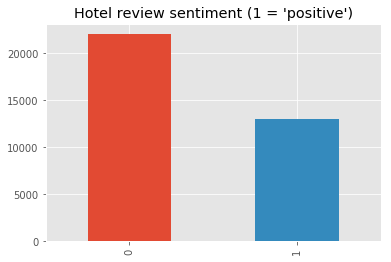

In [7]:
data.sentiment.value_counts().plot(kind='bar')
plt.title("Hotel review sentiment (1 = 'positive')")

In [8]:
# Cleaning text
def clean(review):
        review = str(review)
        review = str(review.lower())  # Lower case
        review = re.compile('[^a-z]+').sub(' ', str(review)).strip() # Remove non alphabetical numbers
        return review

# Add column review cleaned    
data['review_cleaned'] = [clean(x) for x in data['reviews.text']]

In [9]:
# Sanity check
print(data['reviews.text'][0])
print('-----------')
print(data['review_cleaned'][0])

Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!
-----------
pleasant min walk along the sea front to the water bus restaurants etc hotel was comfortable breakfast was good quite a variety room aircon didn t work very well take mosquito repelant


In [10]:
# Split dataset into train and test
data_senti = data[["sentiment" , "review_cleaned"]]
train = data_senti.sample(frac=0.8,random_state=200)
test = data_senti.drop(train.index)

print(len(train))
print(len(test))

28040
7010


In [11]:
# Call up stopwords
stopwords = STOPWORDS
stopwords.remove('not')
stopwords.remove('no')

In [12]:
# Vectorize reviews for classification: random forest, linear regression, SVM, BernouliNB, etc

# Call tfidf vectorizer, fit and transform the data 
count_vect = CountVectorizer(min_df = 2, stop_words = stopwords , ngram_range = (1,2))
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(train["review_cleaned"])        
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(test["review_cleaned"])        
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

#tfidf_vect = TfidfVectorizer(min_df = 2, stop_words = stopwords, ngram_range=(1, 2))
#X_train_tfidf = tfidf_vect.fit_transform(train['review_cleaned'])
#X_test_tfidf = tfidf_vect.fit_transform(test['review_cleaned'])

y_train = train['sentiment']
y_test = test['sentiment']

In [13]:
# Evaluate dimensionality
print('X_train:', X_train_tfidf.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test_tfidf.shape)
print('y_test:', y_test.shape)

X_train: (28040, 89627)
y_train: (28040,)
X_test: (7010, 89627)
y_test: (7010,)


## Training the model

Given that we are trying to predict whether the review was positive or negative, this involves a binary classification task. Since there is a variety of classifiers for this task with different strengths and weakneses, we attempt to try some of them and compare their performace. Here we will be testing the following classifiers: Logistic Regression, Multinomial N(aive) B(ayes), Bernoulli N(aive) B(ayes), Random Forest, KNeighbors classifier, and SVC. 

Notice that the KNeighbors and SVC models were run but they were discarded from further use because their performance was lower than the other classifiers and, most importantly for exposition purposes, they had a runtime of approximately 14 hours.  

These classifiers will be evaluated with regard to their accuracy in both the train and test data, prediction accuracy and log loss. A dataframe is created to store this information and another dataframe to contain the review predictions for each classifier. 

After running the models, we find that the BernoulliNB classifier obtains the highest performance: 75.69%. Since we are working with imbalanced data, accuracy may not be the best metric for this problem. Given that we are interested on whether the review was classified as positive or negative, we will use the ROC AUC as a secondary metric. Here, the BernoulliNB classifier also shows the highest performance:  ROC AUC: 0.77. 

In [14]:
classifiers = [linear_model.LogisticRegression(solver='lbfgs' , C=10000), 
              MultinomialNB(), 
              BernoulliNB(), 
              RandomForestClassifier(n_estimators=20, max_depth=30, random_state=30)]

In [15]:
# Define a function for classifiers without KNeighbors and SVC because they do not perform well for this project
# and they take very long to run

# Define a function to run the classifiers
def run_classifiers(X_train, X_test, y_train, y_test, classifiers):
    # Create a dataframe with results
    results_cols = ['Classifier', 'Train score', 'Test score', 'Accuracy', 'Log Loss']
    results = pd.DataFrame(columns = results_cols)

    predictions_cols = [x.__class__.__name__ for x in classifiers]
    global predictions
    predictions = pd.DataFrame()

    for clf in classifiers:
        clf.fit(X_train, y_train)
    
        name = clf.__class__.__name__
    
        print('='*30)
        print(name)
    
        print('**** Results ****')
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        print('Train score: {:.4%}'.format(train_score))
        print('Test score: {:.4%}'.format(test_score))
    
        prediction = clf.predict(X_test)
        acc = accuracy_score(y_test, prediction)
        print("Accuracy: {:.4%}".format(acc))
        log_predictions = pd.DataFrame(prediction.tolist())
        predictions = pd.concat([predictions, log_predictions], axis = 1)
    
    
        try:
            train_predictions = clf.predict_proba(X_test)
            ll = log_loss(y_test, train_predictions)
            print("Log Loss: {}".format(ll))
        except:
            ll = 'Not applicable'
    
        #acc and ll have been removed
        log_entry = pd.DataFrame([[name, train_score, test_score, acc, ll]], columns = results_cols)
        results = results.append(log_entry)
        
    # Get results in one view
    print(results.head())
    predictions.columns = predictions_cols
    print('*' * 40)
    print(predictions.head())
    
    
    # ROC curve
    cmp = 0
    colors = ['b', 'g', 'y', 'm']
    for model, predict in predictions.items():
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
        cmp += 1

    plt.title('Classifiers  ROC AUC')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.show()

LogisticRegression
**** Results ****
Train score: 98.0884%
Test score: 73.1954%
Accuracy: 73.1954%
Log Loss: 1.599029948996817
MultinomialNB
**** Results ****
Train score: 83.4629%
Test score: 74.2939%
Accuracy: 74.2939%
Log Loss: 0.49556609892741993
BernoulliNB
**** Results ****
Train score: 82.7960%
Test score: 75.6919%
Accuracy: 75.6919%
Log Loss: 1.461166745324262
RandomForestClassifier
**** Results ****
Train score: 72.3502%
Test score: 66.8616%
Accuracy: 66.8616%
Log Loss: 0.5856102467161411
               Classifier  Train score  Test score  Accuracy  Log Loss
0      LogisticRegression     0.980884    0.731954  0.731954  1.599030
0           MultinomialNB     0.834629    0.742939  0.742939  0.495566
0             BernoulliNB     0.827960    0.756919  0.756919  1.461167
0  RandomForestClassifier     0.723502    0.668616  0.668616  0.585610
****************************************
   LogisticRegression  MultinomialNB  BernoulliNB  RandomForestClassifier
0                   0      

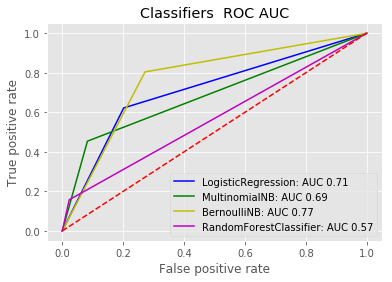

In [16]:
# Run classifiers
run_classifiers(X_train_tfidf, X_test_tfidf, y_train, y_test, classifiers)

### Change the threshold for review sentiment

When providing feedback on a social platform, users sometimes avoid giving a strong rating. That is, we find that a number of users do not use the rating scale fully, but they refrain from grating a 10 or 0 rating in a 10-based scale. In order to account for this phenomenon, here we will adjust the threshold for assigning a review as positive or negative in order to capture the most polarized sentiment in these reviews: ratings equal or higher than 6 will be classify as positive and ratings equal or smaller than 3 will be classified as negative. 

Notice the highly imbalanced data obtained with a strong bias towards the negative class. In order to account for this, we will upsample the positive class and downsample the negative class to make them each having 1500 samples.

After this step, the same modeling steps as in the previous section will be followed. 

Notice that all these models seem to perform very well, higher than 90% each. This is a little bit too suspicious compared to the previous models. One reason for this very high performance could be related to the resampling of the data, especially the relatively large oversampling and downsampling. This, in turn, may have had the effect of refucing the variability in the data making it more prone to overfitting, especially when the test set comes from the resampled data. Another possibility is that the models are actually picking up a signal now that the rating threshold has change. We will keep under consideration as we evaluate additional methods.

In [17]:
# Reorganize the data into positive and negative reviews with a more conservative margin
# Positive => 7; Negative =< 3

# Create column with binary values for sentiment
data["sentiment_conservative"] = [1 if x >= 6 else 0 if x <= 3 else 'None' for x in data['reviews.rating']]
print(data['sentiment_conservative'].value_counts()) 

# Create data_cs with only the positive and negative values 
data_cs = data.loc[data['sentiment_conservative'].isin([1,0])]
print(len(data_cs))
print(data_cs['sentiment_conservative'].value_counts())

None    22605
0       12103
1         342
Name: sentiment_conservative, dtype: int64
12445
0    12103
1      342
Name: sentiment_conservative, dtype: int64


In [18]:
# Resampling: upsampling and downsampling

# Separate the classes
positive_cs = data_cs[data_cs.sentiment_conservative == 1]
negative_cs = data_cs[data_cs.sentiment_conservative != 1]

# Perform up and downsampling
positive_cs_upsample = resample(positive_cs, replace=True, n_samples=1500, random_state=123)
negative_cs_downsample = resample(negative_cs, replace=False, n_samples=1500, random_state=123)

# Concatenate the resampled dataframes
data_cs_resampled = pd.concat([positive_cs_upsample, negative_cs_downsample])

# Split dataset into train and test
data_senti_cs_resampled = data_cs_resampled[["sentiment_conservative" , "review_cleaned"]] # dataframe with only 2 columns
train_cs_resampled = data_senti_cs_resampled.sample(frac=0.8,random_state=200)
test_cs_resampled = data_senti_cs_resampled.drop(train.index)

In [19]:
# Vectorize reviews from resampled dataset
count_vect = CountVectorizer(min_df = 2, stop_words = stopwords , ngram_range = (1,2)) # Reset CountVectorizer
tfidf_transformer = TfidfTransformer()                                                 # Reset TfidfTransformer

X_train_counts_cs_resampled = count_vect.fit_transform(train_cs_resampled["review_cleaned"])        
X_train_tfidf_cs_resampled = tfidf_transformer.fit_transform(X_train_counts_cs_resampled)

X_test_counts_cs_resampled = count_vect.transform(test_cs_resampled["review_cleaned"])        
X_test_tfidf_cs_resampled = tfidf_transformer.transform(X_test_counts_cs_resampled)

y_train_cs_resampled = train_cs_resampled['sentiment_conservative'].astype('int')
y_test_cs_resampled = test_cs_resampled['sentiment_conservative'].astype('int')

LogisticRegression
**** Results ****
Train score: 99.9583%
Test score: 99.3092%
Accuracy: 99.3092%
Log Loss: 0.015718726019979153
MultinomialNB
**** Results ****
Train score: 98.1667%
Test score: 97.4093%
Accuracy: 97.4093%
Log Loss: 0.1624447931612195
BernoulliNB
**** Results ****
Train score: 90.7500%
Test score: 91.3644%
Accuracy: 91.3644%
Log Loss: 0.35380962933480803
RandomForestClassifier
**** Results ****
Train score: 96.8333%
Test score: 94.1278%
Accuracy: 94.1278%
Log Loss: 0.31145346835904997
               Classifier  Train score  Test score  Accuracy  Log Loss
0      LogisticRegression     0.999583    0.993092  0.993092  0.015719
0           MultinomialNB     0.981667    0.974093  0.974093  0.162445
0             BernoulliNB     0.907500    0.913644  0.913644  0.353810
0  RandomForestClassifier     0.968333    0.941278  0.941278  0.311453
****************************************
   LogisticRegression  MultinomialNB  BernoulliNB  RandomForestClassifier
0                   1 

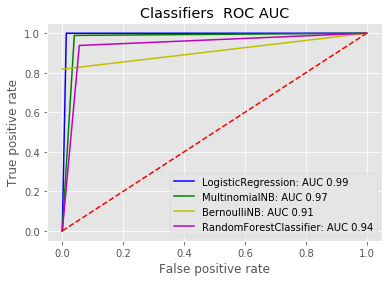

In [20]:
# Run the classifiers
run_classifiers(X_train_tfidf_cs_resampled, X_test_tfidf_cs_resampled, y_train_cs_resampled, y_test_cs_resampled, classifiers)

### Neural network analysis

An alternative to the models analyzed above is to use neural networks to predict the class of the review. In this section, we explored neural networks with different levels of complexity in order to search for a model with better performance than the algorithms created earlier. Since we are dealing with textual data that has been transformed into a numerical representation, it is possible that the neural network identifies certain patterns (in the hidden) layers that are not available to the other classifiers and thus enhance its performance. Notice that for this initial step of testing neural networks, the threshold for hotel reviews is: negative equal or less than 5 and positive everyting else. 

Notice that the three neural networks models tried here produce results less accurate than the BernoulliNB (75%) classifier. Possibly, making the neural network more complex in terms of the number of hidden layers and nodes within them could improve the model's performance. However, we will refrain from that approach here because that will make the models runtime much longer ( > 12 hours). 

Instead, different tokenization methods for the text data such as binary and frequency will be explored. The rationale behind this is that the way in which the text data is transformed into a numerical vector may play an important role in making the signal stronger. 

With a simple neural network of one hidden layers and 100 nodes, none of the tokenization methods tried (binary, frequency, count, tf-idf) showed a performance higher than the BernoulliNB classifier. Again, as in the previous trial, increasing the model's complexity could  improve performance but be much costly in terms of runtime. Instead of doing that, feature engineering will be explored instead. 

In [21]:
# Neural network analysis

# Pre_process data
# Note this data has 1 for reviews >=5 and 0 for everyting lower

# Convert target data into categorical and then to a matrix
from keras.utils import to_categorical

y_nn = to_categorical(data_senti.sentiment)
y_nn = np.asmatrix(y_nn)

# Create data for variable X
X_nn = data_senti.review_cleaned
X_nn = count_vect.fit_transform(X_nn)        
X_nn = tfidf_transformer.fit_transform(X_nn)

print(X_nn.shape)
print(y_nn.shape)
print(type(X_nn))
print(type(y_nn))

Using TensorFlow backend.


(35050, 110680)
(35050, 2)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>


In [22]:
# Create a simple neural network
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

input_shape = X_nn.shape[1]
early_stopping_monitor = EarlyStopping(patience=2)  # Stop after two epochs without any improvement in the model's performance

# Neural network with one hidden layer and 100 nodes
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(input_shape, ))) #Input shape: number of columns of X
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_nn, y_nn, validation_split=0.25, epochs=20, callbacks=[early_stopping_monitor])

Train on 26287 samples, validate on 8763 samples
Epoch 1/20
26287/26287 [==============================] - 120s 5ms/step - loss: 0.4935 - acc: 0.7542 - val_loss: 0.4912 - val_acc: 0.7500
Epoch 2/20
26287/26287 [==============================] - 138s 5ms/step - loss: 0.2397 - acc: 0.8993 - val_loss: 0.6016 - val_acc: 0.7324
Epoch 3/20
26287/26287 [==============================] - 154s 6ms/step - loss: 0.1052 - acc: 0.9545 - val_loss: 0.7431 - val_acc: 0.7204


In [23]:
# Neural netwrok with two hidden layers (100 nodes each)
model_2 = Sequential()
model_2.add(Dense(100, activation='relu', input_shape=(input_shape, ))) #Input shape: number of columns of X
model_2.add(Dense(100, activation='relu'))
model_2.add(Dense(2, activation='softmax'))
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.fit(X_nn, y_nn, validation_split=0.25, epochs=20, callbacks=[early_stopping_monitor])

Train on 26287 samples, validate on 8763 samples
Epoch 1/20
26287/26287 [==============================] - 127s 5ms/step - loss: 0.4900 - acc: 0.7516 - val_loss: 0.4923 - val_acc: 0.7471
Epoch 2/20
26287/26287 [==============================] - 144s 5ms/step - loss: 0.2137 - acc: 0.9072 - val_loss: 0.6393 - val_acc: 0.7248
Epoch 3/20
26287/26287 [==============================] - 149s 6ms/step - loss: 0.0951 - acc: 0.9550 - val_loss: 0.9345 - val_acc: 0.7201


In [24]:
# Model 3: 1 hidden layer, 250 nodes
model_3 = Sequential()
model_3.add(Dense(250, activation='relu', input_shape=(input_shape, ))) #Input shape: number of columns of X
model_3.add(Dense(2, activation='softmax'))
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_3.fit(X_nn, y_nn, validation_split=0.25, epochs=20, callbacks=[early_stopping_monitor])

Train on 26287 samples, validate on 8763 samples
Epoch 1/20
26287/26287 [==============================] - 303s 12ms/step - loss: 0.4887 - acc: 0.7535 - val_loss: 0.4941 - val_acc: 0.7510
Epoch 2/20
26287/26287 [==============================] - 324s 12ms/step - loss: 0.2266 - acc: 0.9013 - val_loss: 0.6180 - val_acc: 0.7256
Epoch 3/20
26287/26287 [==============================] - 313s 12ms/step - loss: 0.1013 - acc: 0.9529 - val_loss: 0.7988 - val_acc: 0.7225


In [25]:
### Neural networks second part - tokenization

# Import keras tokenizer
from keras.preprocessing.text import Tokenizer

def nn_tokenizer(data, mode):
    '''Define function to convert X text data into numerical data though different tokenization modes'''
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    X_nn = tokenizer.texts_to_matrix(data, mode=mode)
    return X_nn

In [26]:
# Define a simple model for neural network

def snn_model(X, y, input_shape):
    '''Define a model, compile and fit it: return accuracy scores'''
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(input_shape, ))) #Input shape: number of columns of X
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X, y, validation_split=0.25, epochs=20, callbacks=[early_stopping_monitor], verbose=2)
    scores.append(history.history.keys())

In [27]:
# Define different modes
modes = ['binary', 'count', 'tfidf', 'freq']

# Define list of scores to record the results
scores = []

# Run the different methods and score the scores

for mode in modes:
    X_nn = nn_tokenizer(data_senti.review_cleaned, mode)
    input_shape = X_nn.shape[1] 
    snn_model(X_nn, y_nn, input_shape=input_shape)

Train on 26287 samples, validate on 8763 samples
Epoch 1/20
 - 38s - loss: 0.4901 - acc: 0.7609 - val_loss: 0.4955 - val_acc: 0.7532
Epoch 2/20
 - 49s - loss: 0.3733 - acc: 0.8256 - val_loss: 0.5287 - val_acc: 0.7461
Epoch 3/20
 - 47s - loss: 0.2813 - acc: 0.8734 - val_loss: 0.6110 - val_acc: 0.7362
Train on 26287 samples, validate on 8763 samples
Epoch 1/20
 - 38s - loss: 0.4901 - acc: 0.7611 - val_loss: 0.4918 - val_acc: 0.7561
Epoch 2/20
 - 36s - loss: 0.3741 - acc: 0.8244 - val_loss: 0.5224 - val_acc: 0.7468
Epoch 3/20
 - 38s - loss: 0.2772 - acc: 0.8786 - val_loss: 0.5879 - val_acc: 0.7403
Train on 26287 samples, validate on 8763 samples
Epoch 1/20
 - 40s - loss: 0.4992 - acc: 0.7578 - val_loss: 0.4987 - val_acc: 0.7497
Epoch 2/20
 - 38s - loss: 0.3293 - acc: 0.8479 - val_loss: 0.5821 - val_acc: 0.7402
Epoch 3/20
 - 35s - loss: 0.2196 - acc: 0.9052 - val_loss: 0.7039 - val_acc: 0.7307
Train on 26287 samples, validate on 8763 samples
Epoch 1/20
 - 38s - loss: 0.5482 - acc: 0.7162 -

## Part of speech tagging

In this section, we will develop a feature that relates each individual word item in the text reviews and associates it with a part of speech (pos) tag, e.g. noun or verb. The rationale behind this is to disambiguate or distinguish the meaning associated with the same form of a word but that plays a different function in a context depending on its part of speech. Thus, this feature allows us to incorporate some of the contextual information in the analysis of the hotel reviews that otherwise was not available. This feature pos creates a column in which each word is associated with its corresponding part of speech into a single string for later vectorization. 

In adding this information, it is the BernoulliNB classifier that outperforms the rest. When comparing the results of the current model with that of the model without pos information, the former outperforms the latter by a couple of centesimal points. Thus, it is likely that adding the pos information helps into picking up a signal for distinguishing the classes. BEcause of this, we will keep this feature for further improvement. 

In [28]:
# Add pos tagging to the bag of words
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Create column with cleaned text (str, lower case); tokenize it and add part of speech    
data['pos'] = [clean(x) for x in data['reviews.text']]
print(data['pos'][0])
(print('=' * 30))

# Remove stop words
stoplist = set(stopwords.words('english'))
data['pos'] = data['pos'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))
print(data['pos'][0])
(print('=' * 30))

# Tokenize and add part of speech
data['pos'] = [pos_tag(word_tokenize(x)) for x in data['pos']]
print(data['pos'][0])
(print('=' * 30))

# Join tuples into a single string for each row
data['pos'] = [[''.join(tup) for tup in row] for row in data['pos']]
print(data['pos'][0])
(print('=' * 30))

# Convert a list of strings into a single string
data['pos'] = [' '.join(x) for x in data['pos']]
print(data['pos'][0])

pleasant min walk along the sea front to the water bus restaurants etc hotel was comfortable breakfast was good quite a variety room aircon didn t work very well take mosquito repelant
pleasant min walk along sea front water bus restaurants etc hotel comfortable breakfast good quite variety room aircon work well take mosquito repelant
[('pleasant', 'JJ'), ('min', 'NN'), ('walk', 'NN'), ('along', 'IN'), ('sea', 'NN'), ('front', 'JJ'), ('water', 'NN'), ('bus', 'NN'), ('restaurants', 'NNS'), ('etc', 'JJ'), ('hotel', 'NN'), ('comfortable', 'JJ'), ('breakfast', 'NN'), ('good', 'JJ'), ('quite', 'RB'), ('variety', 'NN'), ('room', 'NN'), ('aircon', 'NN'), ('work', 'NN'), ('well', 'RB'), ('take', 'VB'), ('mosquito', 'NN'), ('repelant', 'NN')]
['pleasantJJ', 'minNN', 'walkNN', 'alongIN', 'seaNN', 'frontJJ', 'waterNN', 'busNN', 'restaurantsNNS', 'etcJJ', 'hotelNN', 'comfortableJJ', 'breakfastNN', 'goodJJ', 'quiteRB', 'varietyNN', 'roomNN', 'airconNN', 'workNN', 'wellRB', 'takeVB', 'mosquitoNN', '

In [29]:
# Split dataset into train and test
data_pos = data[["sentiment" , "pos"]]
train_pos = data_pos.sample(frac=0.8,random_state=200)
test_pos = data_pos.drop(train_pos.index)

print(len(train_pos))
print(len(test_pos))

28040
7010


In [30]:
print(train_pos['pos'][0])
print(type(train_pos['pos'][0]))

pleasantJJ minNN walkNN alongIN seaNN frontJJ waterNN busNN restaurantsNNS etcJJ hotelNN comfortableJJ breakfastNN goodJJ quiteRB varietyNN roomNN airconNN workNN wellRB takeVB mosquitoNN repelantNN
<class 'str'>


In [31]:
# Vectorize reviews for classification: random forest, linear regression, SVM, BernouliNB, etc

# Call tfidf vectorizer, fit and transform the data 
count_vect = CountVectorizer(min_df = 2, stop_words = None, ngram_range = (1, 2))
tfidf_transformer = TfidfTransformer()

X_train_pos_counts = count_vect.fit_transform(train_pos["pos"])        
X_train_pos_tfidf = tfidf_transformer.fit_transform(X_train_pos_counts)

X_test_pos_counts = count_vect.transform(test_pos["pos"])        
X_test_pos_tfidf = tfidf_transformer.transform(X_test_pos_counts)

y_train = train_pos['sentiment']
y_test = test_pos['sentiment']

LogisticRegression
**** Results ****
Train score: 98.2168%
Test score: 73.3666%
Accuracy: 73.3666%
Log Loss: 1.7117901167757348
MultinomialNB
**** Results ****
Train score: 83.3987%
Test score: 73.6947%
Accuracy: 73.6947%
Log Loss: 0.5071141746802602
BernoulliNB
**** Results ****
Train score: 84.1833%
Test score: 75.8773%
Accuracy: 75.8773%
Log Loss: 1.312334423350751
RandomForestClassifier
**** Results ****
Train score: 70.1534%
Test score: 65.9914%
Accuracy: 65.9914%
Log Loss: 0.6030410247560132
               Classifier  Train score  Test score  Accuracy  Log Loss
0      LogisticRegression     0.982168    0.733666  0.733666  1.711790
0           MultinomialNB     0.833987    0.736947  0.736947  0.507114
0             BernoulliNB     0.841833    0.758773  0.758773  1.312334
0  RandomForestClassifier     0.701534    0.659914  0.659914  0.603041
****************************************
   LogisticRegression  MultinomialNB  BernoulliNB  RandomForestClassifier
0                   1      

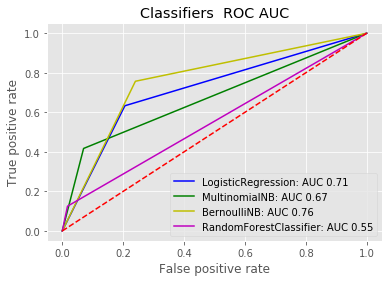

In [32]:
run_classifiers(X_train_pos_tfidf, X_test_pos_tfidf, y_train, y_test, classifiers)

## Add additional feature beyond review (textual)

In this section, additional textual data will be added to the model. Especifically, the textual data cotained in the review title will also be considered when modeling in addition to the review itself. By having a larger dataset with richer information, it is expected to increase the model's performance. 

In order to do this, both the review and title textual data will be preprocessed in the same fashion as done above. That is, change it to lowercase, remove stopwords, etc. In addition, each word in the review and title will be associated with its corresponding part of speech, as this proved to increase the model's performance. Then, each of those features, review and title, will be vectorized. The next step consists of merging the dataset containing the review inofrmation with the title dataframe. Attempting this with the data as it is outruns the memory of the computer in which this model is run and shuts it down. In order to avoid this technical difficulty, the number of the reviews' features will be reduced to 5000 most important ones through chi-square. Once this is done, the two dataframes are concatenated. 

The next step is to run the same classifiers as before. Overall, all the classifiers performance increased by adding the textual data. Now, the MultinomialNB shows the hihgest accuracy followed by the BernoulliNB classifier. However, since the dataset is imbalanced towards the negative class, a different metric could provide a more accurate image of the models performance. Here, the ROC area under the curve provides a better view of it. Now, it is again the BernoulliNB classifier that shows the highest performance with a .80 AUC, which is an relatively considerable increased from the previous model. For the next trial, both the review and title of the review will be kept as it increases the model performance. 

In [33]:
# Make a copy of the dataframe to add the additional features
data_moref = data.copy()

## Clean both review and title (notice that review is already cleaned)
# Remove stop words in review
data_moref['review_cleaned'] = data_moref['review_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))

# Clean and remove stopwords in title
data_moref['title_cleaned'] = [clean(x) for x in data_moref['reviews.title']]
data_moref['title_cleaned'] = data_moref['title_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))

## Tokenize and add part of speech for review title
data_moref['title_pos'] = [pos_tag(word_tokenize(x)) for x in data_moref['title_cleaned']]

# Join tuples into a single string for each row
data_moref['title_pos'] = [[''.join(tup) for tup in row] for row in data_moref['title_pos']]

# Convert a list of strings into a single string
data_moref['title_pos'] = [' '.join(x) for x in data_moref['title_pos']]
print(data_moref['title_pos'][0])

goodJJ locationNN awayRB croudsNNS


In [34]:
data_moref.head(2)

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,...,reviews.title,reviews.userCity,reviews.username,reviews.userProvince,sentiment,review_cleaned,sentiment_conservative,pos,title_cleaned,title_pos
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,...,Good location away from the crouds,NaN,Russ (kent),NaN,0,pleasant min walk along sea front water bus re...,None,pleasantJJ minNN walkNN alongIN seaNN frontJJ ...,good location away crouds,goodJJ locationNN awayRB croudsNNS
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN,1,really lovely hotel stayed top floor surprised...,None,reallyRB lovelyJJ hotelNN stayedVBD topJJ floo...,great hotel jacuzzi bath,greatJJ hotelNN jacuzziNN bathNN


In [35]:
# Split dataset into train and test
train_moref = data_moref.sample(frac=0.8,random_state=200)
test_moref = data_moref.drop(train.index)

print(len(train))
print(len(test))

28040
7010


In [36]:
## Vectorize and tf-idf for both title and review

# Call tfidf vectorizer, fit and transform the data 
# Here the HashingVectorizer will be used instead of the CountVectorizer in order to save memory
count_vect_review = CountVectorizer(min_df = 2, stop_words = None , ngram_range = (1,2))
tfidf_transformer_review = TfidfTransformer()

## Vectorize review
# Vectorize review for X train
X_train_review = count_vect_review.fit_transform(train_moref["pos"])        
X_train_review_tfidf = tfidf_transformer_review.fit_transform(X_train_review)

# Vectorize review for X test
X_test_review = count_vect_review.transform(test_moref["pos"])        
X_test_review_tfidf = tfidf_transformer_review.transform(X_test_review)


## Vectorize title
# Reset vectorizer
count_vect_title = CountVectorizer(min_df = 2, stop_words = None , ngram_range = (1,2))
tfidf_transformer_title = TfidfTransformer()

# Vectorize title for X train
X_train_title = count_vect_title.fit_transform(train_moref["title_pos"])        
X_train_title_tfidf = tfidf_transformer_title.fit_transform(X_train_title)

# Vectorize title for X test
X_test_title = count_vect_title.transform(test_moref["title_pos"])        
X_test_title_tfidf = tfidf_transformer_title.transform(X_test_title)


# Separate the y for train and test
y_train_moref = train_moref['sentiment']
y_test_moref = test_moref['sentiment']

# Check shape of created variables
print('X_train review:', X_train_review_tfidf.shape)
print('X_test review:', X_test_review_tfidf.shape)
print('X_train title:', X_train_title_tfidf.shape)
print('X_test title:', X_test_title_tfidf.shape)
print('y_train:', y_train_moref.shape)
print('y_test:', y_test_moref.shape)

X_train review: (28040, 93905)
X_test review: (7010, 93905)
X_train title: (28040, 11260)
X_test title: (7010, 11260)
y_train: (28040,)
y_test: (7010,)


In [37]:
## Create dataframes for X_train review and title
# Convert review sparse matrix into dataframe
X_train_review_df = pd.DataFrame(X_train_review_tfidf.todense())
X_train_review_df.columns = count_vect_review.get_feature_names()

# Convert title sparse matrix into dataframe
X_train_title_df = pd.DataFrame(X_train_title_tfidf.todense())
X_train_title_df.columns = count_vect_title.get_feature_names()


## Create dataframes for X_test review and title
# Create dataframe for X_test review
X_test_review_df = pd.DataFrame(X_test_review_tfidf.todense())
X_test_review_df.columns = count_vect_review.get_feature_names()

# Create dataframe for X_test title
X_test_title_df = pd.DataFrame(X_test_title_tfidf.todense())
X_test_title_df.columns = count_vect_title.get_feature_names()

print('X_train review', X_train_review_df.shape)
print('X_train title', X_train_title_df.shape)
print('X_test review', X_test_review_df.shape)
print('X_test title', X_test_title_df.shape)

X_train review (28040, 93905)
X_train title (28040, 11260)
X_test review (7010, 93905)
X_test title (7010, 11260)


#### Apply dimensionality reduction to handle overhead memory constraints when merging dataframes. 

In [38]:
# Apply dimensionality reduction to handle overhead memory constraints

# Vectorize reviews 
count_vect_review = CountVectorizer(min_df = 2, stop_words = None , ngram_range = (1,2))
tfidf_transformer_review = TfidfTransformer()

review = count_vect_review.fit_transform(data_moref['pos'])        
review_tfidf = tfidf_transformer_review.fit_transform(review)
print(review_tfidf.shape)


# Vectorize title
count_vect_title = CountVectorizer(min_df = 2, stop_words = None , ngram_range = (1,2))
tfidf_transformer_title = TfidfTransformer()

title = count_vect_title.fit_transform(data_moref['title_pos'])        
title_tfidf = tfidf_transformer_title.fit_transform(title)
print(title_tfidf.shape)

(35050, 116926)
(35050, 13926)


In [39]:
# Reduce dimensionality of review

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Find the 5000 most informative words
selector = SelectKBest(chi2, k=5000)
selector.fit(review_tfidf, data_moref['sentiment'])

top_words_review = selector.get_support().nonzero()

# Create dataframe with only the top 5000 words
review_top_5k = review_tfidf[:,top_words_review[0]]


# Reduce dimensionality of title
selector = SelectKBest(chi2, k=5000)
selector.fit(title_tfidf, data_moref['sentiment'])

top_words_title = selector.get_support().nonzero()

title_top_5k = title_tfidf[:,top_words_title[0]]


# Convert matrices to dataframe
review_df = pd.DataFrame(review_top_5k.todense())
#review_df.columns = review.get_feature_names()[:,top_words_review[0]]  # Add column names

title_df = pd.DataFrame(title_top_5k.todense())
#title_df.columns = title.get_feature_names()[:,top_words_title[0]]    # Add column names


# Concatenate dataframes
features = pd.concat([review_df, title_df], axis=1)
print(features.shape)
print('Expected shape:', 35050, 10000)

# Rename columns since there were two sets of columns from 0 to 4999
features.columns.values[:] = np.arange(10000) 

# Add targe variable
features['sentiment'] = [int(round(x)) for x in data_moref['sentiment']]

# Drop na values
features.dropna()
print('After dropping na:', features.shape)

(35050, 10000)
Expected shape: 35050 10000
After dropping na: (35050, 10001)


In [40]:
type(features['sentiment'][1])

numpy.int64

In [41]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(features[features.columns.difference(['sentiment'])], features['sentiment'], test_size=0.25, random_state=123)

LogisticRegression
**** Results ****
Train score: 88.5419%
Test score: 79.5960%
Accuracy: 79.5960%
Log Loss: 0.481867219396902
MultinomialNB
**** Results ****
Train score: 83.1438%
Test score: 81.0910%
Accuracy: 81.0910%
Log Loss: 0.4069902935904946
BernoulliNB
**** Results ****
Train score: 81.5042%
Test score: 79.8699%
Accuracy: 79.8699%
Log Loss: 0.8318596157945343
RandomForestClassifier
**** Results ****
Train score: 78.1489%
Test score: 71.3112%
Accuracy: 71.3112%
Log Loss: 0.5655247174999638
               Classifier  Train score  Test score  Accuracy  Log Loss
0      LogisticRegression     0.885419    0.795960  0.795960  0.481867
0           MultinomialNB     0.831438    0.810910  0.810910  0.406990
0             BernoulliNB     0.815042    0.798699  0.798699  0.831860
0  RandomForestClassifier     0.781489    0.713112  0.713112  0.565525
****************************************
   LogisticRegression  MultinomialNB  BernoulliNB  RandomForestClassifier
0                   0      

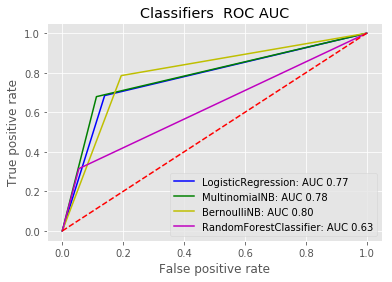

In [42]:
# Run classifiers
run_classifiers(X_train, X_test, y_train, y_test, classifiers)

### Add non-textual features

In this last section, meta-features or features related to the size, form and sentence type of the review are added to the dataset containing both review and title information from the previous section. Then, the same models as in the previous sections are run. 

Overall, applying this approach decreases the models accuracy as well as ROC area under the curve with the exception of the BernoulliNB classifier that stays at .80. Given this results, it seems that adding the meta features makes the models more complex without any significant gain in performance. Because of this, the metafeatures will not be included in the final version of the model. 

In [43]:
# Add further features contained in the dataset

# Add meta features
transform_functions = [
    lambda x: len(x),                              # length of review
    lambda x: x.count(" "),                        # number of spaces
    lambda x: x.count("."),                        # number of sentences
    lambda x: x.count("!"),                        # number of exclamation sentences
    lambda x: x.count("?"),                        # number of questions
    lambda x: len(x) / (x.count(" ") + 1),         # ratio of length over spaces
    lambda x: x.count(" ") / (x.count(".") + 1),   # number of spaces per sentence
    lambda x: len(re.findall("\d", x)),            # number of digits
    lambda x: len(re.findall("[A-Z]", x)),         # number of capitalized words
]

# Add these meta features into a column
# Make sure that all rows in 'reviews.text' are string type
data_moref['pos'] = data_moref['pos'].astype(str)

meta = []

# Create column for each meta-feature
for func in transform_functions:
    meta.append(data_moref['pos'].apply(func))
    
# Convert metafeatures to a numpy array and transpose it
meta_ft = np.asarray(meta).T
meta_ft = pd.DataFrame(meta_ft)
cols = ['length', 'spaces', 'full_stop', 'exclamation', 'interrogation', 'ratio_over_spaces', 'spaces_per_sentence', 'digits', 'capitalized_words']
meta_ft.columns = cols

print(meta_ft.shape)

(35050, 9)


In [44]:
# Concatenate both review, title and meta features about review
features_meta = pd.concat([features, meta_ft], axis=1)
print(features_meta.shape)

(35050, 10010)


In [45]:
# Split data into train and split
X_train, X_test, y_train, y_test = train_test_split(features_meta[features_meta.columns.difference(['sentiment'])], features['sentiment'], test_size=0.25, random_state=123)

LogisticRegression
**** Results ****
Train score: 75.6420%
Test score: 74.6092%
Accuracy: 74.6092%
Log Loss: 0.5200543849660549
MultinomialNB
**** Results ****
Train score: 78.1032%
Test score: 76.6062%
Accuracy: 76.6062%
Log Loss: 0.5127377241452364
BernoulliNB
**** Results ****
Train score: 81.5042%
Test score: 79.8471%
Accuracy: 79.8471%
Log Loss: 0.8320947972558765
RandomForestClassifier
**** Results ****
Train score: 79.1228%
Test score: 71.1971%
Accuracy: 71.1971%
Log Loss: 0.561813587429701
               Classifier  Train score  Test score  Accuracy  Log Loss
0      LogisticRegression     0.756420    0.746092  0.746092  0.520054
0           MultinomialNB     0.781032    0.766062  0.766062  0.512738
0             BernoulliNB     0.815042    0.798471  0.798471  0.832095
0  RandomForestClassifier     0.791228    0.711971  0.711971  0.561814
****************************************
   LogisticRegression  MultinomialNB  BernoulliNB  RandomForestClassifier
0                   0      

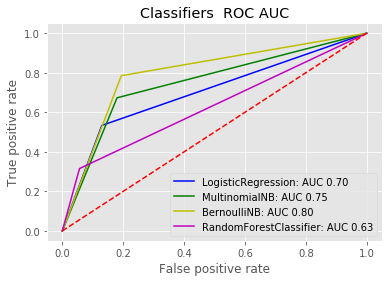

In [46]:
# Run classifiers
run_classifiers(X_train, X_test, y_train, y_test, classifiers)

## Conclusions

The goal of this project was to develop a model to predict whether a hotel review would be positive or negative based on the textual review itself as well as the title. A number of different classifiers including neural networks were trained in order to select the one with the best performance. Out of them, the BernoulliNB classifier showed the highest performance when measured with regard to the ROC area under the curve; although this classifier also showed a high accuracy level. The BernoulliNB classifier showed the highest performance 0.80 ROC AUC when been fed both the review and title textual data in which each word was associated with its corresponding part of speech tag. 

Thus, this model is ready to help hotel stakeholders to evaluate the perception that customers have about their hotels and the service offered there. This model allows to automatize reading the reviews, which in turn can save the proportional amount of monetary resources used to pay human readers. In addition, having such a model provides a more neutral and constant measure to evaluate the hotel reviews, something that could not be achieved when different readers evaluate the reviews. By having this information, hotel stakeholders can identify the main perception of their bussiness and consider ways to improve them. 

Further ways to improve this model involves adding additional features to the dataset such as the location of the reviewer, the location of the reviewed hotel as well as the date in which the review was made in order to have a more fine-grained understanding of this pattern, e.g. hotels in certain areas are better reviewed than hotels in different areas or reviews are better in certain seasons or months. Furthemore, this model could be more insightful by showing which words were more relevant in this model. In other words, identify which concepts users used most in order to better identifies issues with the bussiness. For instance, if reviews marked negatively show the word bathroom, we could conclude that customers are not satisfied with the features of the bathroom and do something about that. Although, incliuding this informaiton was part of the orignial project, it was not included because of technical reasons when performing dimesnionality reduction. However, we believe that adding this feature will make the model more informative. 

### References
https://www.brightlocal.com/2014/08/14/5-visual-stats-power-of-online-reviews/